In [1]:
import nbimporter
from functions import *
import voxelmorph as vxm
import neurite as ne
%matplotlib inline

In [2]:
data_dir='/home/mahdi/Desktop/data_selection_D1'
split=1
batch_size=32
#maximum=maxx(data_dir)
maximum=1584

[[ 0.99939083  0.0348995   0.          0.        ]
 [-0.0348995   0.99939083  0.         -1.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


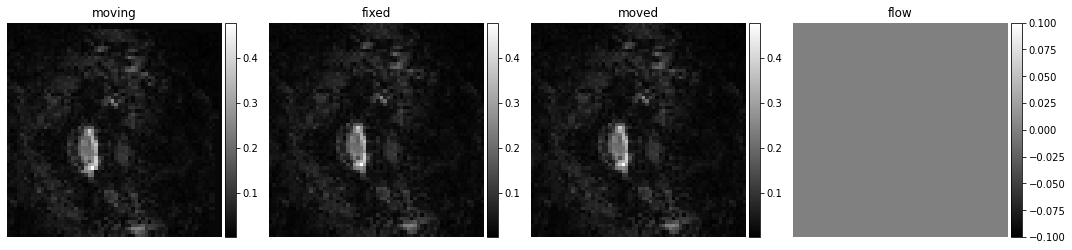

In [3]:
# let's get some data
val_generator = affine_generator(data_dir,batch_size,maximum,split)
val_input, out ,y= val_generator


# visualize
images = [img[0, :, :, 0] for img in val_input + out] 
titles = ['moving', 'fixed', 'moved', 'flow']
print(y[0])
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [5]:
# configure unet input shape (concatenation of moving and fixed images)
ndim = 2
unet_input_features = 2
# data shape 64*64
s=(64,64)
inshape = (*s, unet_input_features)
# configure unet features 
nb_features =[
    [64, 64, 64, 64],         # encoder features
    [64, 64, 64, 64, 64, 32,16]  # decoder features
             ]
# build model using VxmDense
inshape =s
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]
# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights, metrics=['accuracy'])
vxm_model.load_weights('200epoch_with_val.h5')

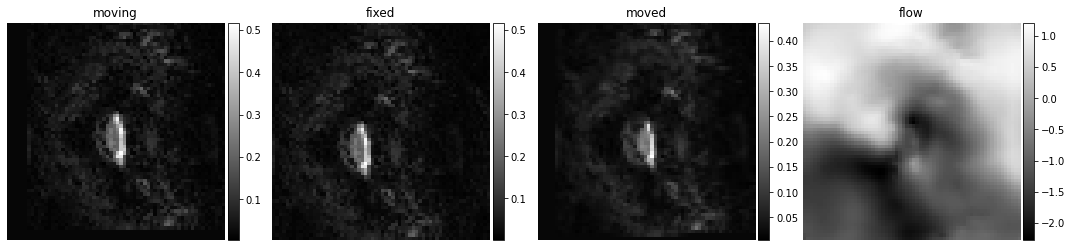

In [15]:
val_pred = vxm_model.predict(val_input)

# visualize
images = [img[1, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);


In [16]:
y[1]

array([[ 1., -0.,  0., -3.],
       [ 0.,  1.,  0.,  6.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

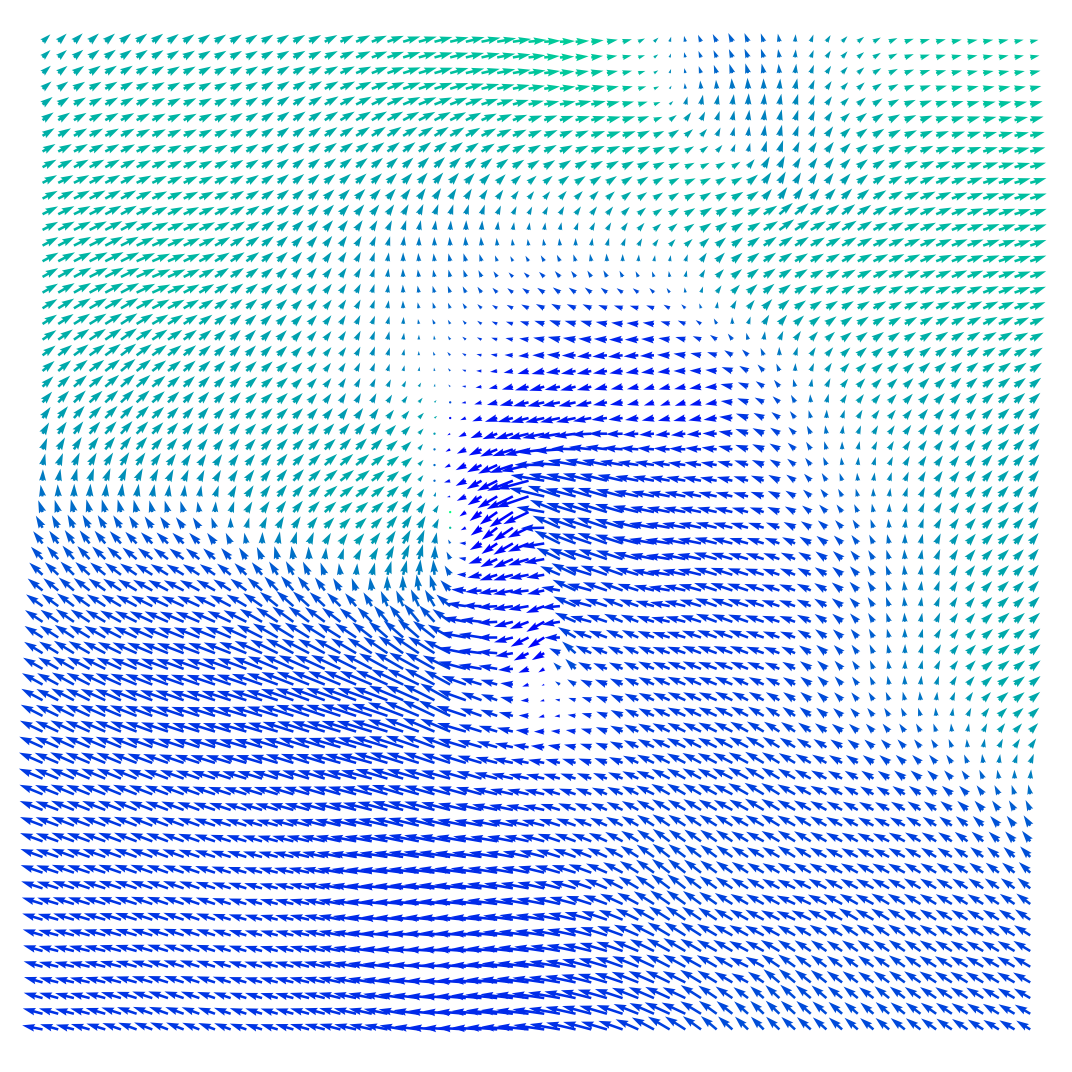

(<Figure size 1080x1080 with 1 Axes>, [<AxesSubplot:>])

In [17]:
ne.plot.flow([val_pred[1][1].squeeze()], width=15)